/tmp/ipykernel_12880/1933183627.py:89: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(r'/home/dhashin/workspace/APSERa/total_spec_new.txt',sep= "    " ,header = None)
/tmp/ipykernel_12880/1933183627.py:105: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  T_sky = (T_hot - T_cold)* np.divide(Total_sky,P_dif)     #Doin

(0.0, 200.0)

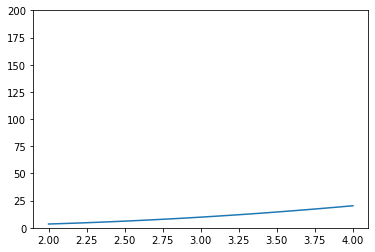

In [3]:
#The following code is written using GlobalSkyModel and not GlobalSkyModel2016. The difference is just the units, and that can be modified anytime.

import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import math
import ephem

%matplotlib inline

from pygsm import GlobalSkyModel



from astropy.time import Time
from astropy.coordinates import Galactic, SkyCoord, FK5, EarthLocation, AltAz, Angle
import astropy.units as u

import pandas as pd
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline


h = 6.62607157e-34
k = 1.3806488e-23
c = 2.99792458e+08
TCMB = 2.72548
f_start = 2
f_stop = 4
No_of_Channels = 21
Channel_width = 0.1
N_SIDE = 16
T_hot = 373
T_cold = 273         #T_cold and T_hot in Kelvins
Time_in_UTC = '2022-05-20 1:45:00'  
latitude = 13.067439
longitude = 80.237617       #Latitude and longitude in degrees
altitude = 0            #Altitude in meters
alpha = 0.0065            #Temp. lapse rate (deg C per meter)
PI = 3.14159265
Noise_int_time = 2.7e10
Trx = 14
T_atm = 1
freqs = np.linspace(f_start,f_stop, No_of_Channels)
CMB_Int = np.empty(No_of_Channels)
P_hot = np.empty(No_of_Channels)
P_cold = np.empty(No_of_Channels)
P_dif = np.empty(No_of_Channels)
cross_real = [0]*No_of_Channels
cross_imag = [0]*No_of_Channels
sumwt = [0]*No_of_Channels
sigma = [0]*No_of_Channels


gsm = GlobalSkyModel(freq_unit='GHz')
spectrum = gsm.generate(freqs)*1.38e-23    
#PyGSM pack has antenna units. Converted to SI units above

spec = hp.pixelfunc.ud_grade(spectrum, N_SIDE)
df = pd.DataFrame(spec)
df = df.transpose()
df.columns = np.arange(f_start,f_stop+Channel_width,Channel_width)

i=0
while i<No_of_Channels:
    #Calculation of CMB intensities at different frequencies below
    CMB_Int[i] = (2*h*math.pow(df.columns[i]*1e9,3.0)/(c*c*math.exp(h*df.columns[i]*1e9/k*TCMB)-1))
    #P_hot and P_cold calculation for calibration below
    P_hot[i] = 2*k*T_hot*(((h*df.columns[i])/(k*T_hot))/(math.exp((h*df.columns[i])/(k*T_hot))-1));   
    P_cold[i] = 2*k*T_cold*(((h*df.columns[i])/(k*T_cold))/(math.exp((h*df.columns[i])/(k*T_cold))-1));   
    P_dif[i] = P_hot[i] - P_cold[i]      
    
    i=i+1
    

CMB = pd.DataFrame(CMB_Int)
CMB = CMB.transpose()
CMB.columns = np.arange(f_start,f_stop+Channel_width,Channel_width)
CMB = CMB.transpose()
df = df.transpose()     #The last few lines are for making a dataframe 

CMB_plus_Gal = np.add(df, CMB.to_numpy())    #Adding CMB and Galactic contribution intensities in SI units. Recombination line intensity is added later.

Obs = ephem.Observer()
t = Time(Time_in_UTC, scale='utc',location=(longitude, latitude))
lst = t.sidereal_time('apparent')

NPIX = hp.nside2npix(N_SIDE)

df = pd.read_csv(r'/home/dhashin/workspace/APSERa/total_spec_new.txt',sep= "    " ,header = None)
df.reset_index(drop=True, inplace=True)
df.columns = ["Frequency","Intensity"]

x = df["Frequency"]
y= df["Intensity"]

ius = InterpolatedUnivariateSpline(x, y)

Rec_int = ius(np.arange(f_start,f_stop+Channel_width,Channel_width))
Rec_spec = pd.DataFrame(Rec_int)
   #Getting intensities at the required frequencies

Total_sky = np.add(CMB_plus_Gal, Rec_spec.to_numpy())     #Adding reco. signal with gala. signal and CMB (All in SI units)
P_dif = pd.DataFrame(P_dif)

T_sky = (T_hot - T_cold)* np.divide(Total_sky,P_dif)     #Doing calibration

def refraction(alt_in_deg, altitude):
    pres = 1010.*math.pow((1-6.5/288000*altitude),5.255)
    if (altitude>11000):
        temp = 211.5
    else:
        temp = 283.0 - (alpha * altitude)
    R = 1.02/math.tan((alt_in_deg + (10.3/(alt_in_deg + 5.11)))*(PI/180))
    if (alt_in_deg == 90):
        R = R+ 0.0019279
    tpcor = (pres/1000) * (283/temp)
    R =  tpcor*(R/60)
    return alt_in_deg +R


def beam_def(freq, az, alt):
    if (alt<=0):
        return 0
    else:
        return (math.sin(alt*PI/180)*math.sin(alt*PI/180))
    
alt = np.empty(NPIX)
az = np.empty(NPIX)

i=1
while i<NPIX:           #Working on each pixel
    coords = hp.pixelfunc.pix2ang(16, i , nest = False, lonlat = True)          #Gives l and b coordinates for each pixel
    gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')
        
        #Now, the coordinates in Galactic frame is changed to equitorial frame below
    equi = gc.transform_to(AltAz(obstime = Time_in_UTC, location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg, height=altitude*u.m)))
    alt = equi.alt.value
    new_alt = refraction(alt, altitude) 
    
    
    
    j=0
    while j< No_of_Channels:
        cwt = beam_def(freqs[j],equi.az.value, new_alt)

        if (cwt>0):
            cross_real[j]= cross_real[j] + cwt * (np.array(T_sky[i-1]))[j]
            sumwt[j] = sumwt[j]+ cwt
        
        j=j+1
    
    i=i+1

#plt.scatter(freqs,cross_real, c='lightblue')
    
i=0    
while(i< No_of_Channels):
    if sumwt[i]>0:
        cross_real[i] = cross_real[i]/sumwt[i]
    i = i+1

    
#Adding thermal noise to the final spectrum    
#For the total power radiometer:

sigma = (np.array(cross_real) + Trx+ T_atm)/ math.sqrt(Channel_width*1e6*Noise_int_time)

#Generating array of random numbers(of length = No.of channels) with mean =0, std = 1 
array = np.random.normal(0,1,No_of_Channels)

cross_real = cross_real + array*sigma
cross_imag = cross_imag + array*sigma

plt.plot(freqs, cross_real)
plt.ylim([0,200])